## **1. Background**

![Natural language processing](https://landbot.io/wp-content/uploads/2019/11/natural-language-processing-chatbot.jpg)

**What is Natural Language Processing?**

From wikipedia, Natural language processing (NLP) is a subfield of linguistics, computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data.

**What is Sentiment Classification?**

Sentiment analysis (also known as opinion mining or emotion AI) refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

**What is Tokenizer?**

Tokenization is a necessary first step in many natural language processing tasks, such as word counting, parsing, spell checking, corpus generation, and statistical analysis of text.

Tokenizer is a compact pure-Python (2 and 3) executable program and module for tokenizing Icelandic text. It converts input text to streams of tokens, where each token is a separate word, punctuation sign, number/amount, date, e-mail, URL/URI, etc. It also segments the token stream into sentences, considering corner cases such as abbreviations and dates in the middle of sentences.[Tokenizer](https://pypi.org/project/tokenizer/)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Serfati/imdb_sentiment_analysis)

In [1]:
# !pip install -r requirements.txt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter

In [3]:
import re
import os
import pandas as pd
import numpy as np

In [4]:
# visualization
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [5]:
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [7]:
# change here to your dataset path

# from google.colab import drive
# drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/imdb_nlp/IMDB Dataset.csv'
PATH = 'IMDB Dataset.csv'

## **2. Data exploratory analysis**


### **2.1 Data overview**

![IMDB 50 review datasets](https://o.aolcdn.com/images/dims?quality=85&image_uri=https%3A%2F%2Fo.aolcdn.com%2Fimages%2Fdims%3Fcrop%3D908%252C537%252C0%252C0%26quality%3D85%26format%3Djpg%26resize%3D1600%252C947%26image_uri%3Dhttps%253A%252F%252Fs.yimg.com%252Fos%252Fcreatr-uploaded-images%252F2019-08%252F560e5d20-c833-11e9-bf26-36635805fe83%26client%3Da1acac3e1b3290917d92%26signature%3D639a4965c41ca6cec13652498f65cfc97170ea5d&client=amp-blogside-v2&signature=765e155477177a69b93eac5611145d4241be6071)

This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.

**Dataset**

The core dataset contains 50,000 reviews. The overall distribution of labels is balanced (25k pos and 25k neg). We also include an additional 50,000 unlabeled documents for unsupervised learning.

### **2.2 Data Exploration**

The first step is to load the data to global environment.

In [8]:
df = pd.read_csv(PATH)

We could see some abnormal words such as <br /><br />, then we should replace them by a null or space value.

Text(0.5, 1.0, 'Words occurrence frequency')

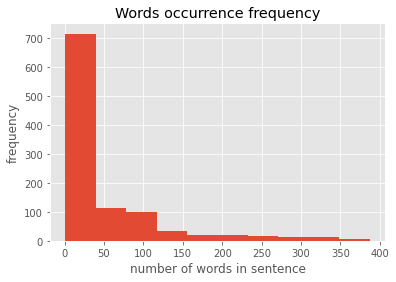

In [9]:
plt.figure()
plt.hist(df['review'].str.split().apply(len).value_counts())
plt.xlabel('number of words in sentence')
plt.ylabel('frequency')
plt.title('Words occurrence frequency')

In [10]:
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [12]:
df["review"][0][:250]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of "

In [13]:
df["sentiment"][0]

'positive'

In [14]:
df["review"].groupby(df["sentiment"]).count()

sentiment
negative    25000
positive    25000
Name: review, dtype: int64

Text(0.5, 1.0, 'Reviews polarity')

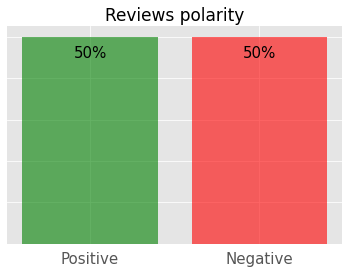

In [15]:
s = df['sentiment'].value_counts()
s = (s/s.sum())*100

plt.figure()
bars = plt.bar(s.index, s.values, color = ['green', 'red'], alpha = .6)
plt.xticks(s.index, ['Positive', 'Negative'], fontsize = 15)
plt.tick_params(bottom = False, top = False, left = False, right = False, labelleft = False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 5, s = str(bar.get_height())[:2] + '%', ha = 'center', fontsize = 15)
plt.title('Reviews polarity', fontsize = 17)

### **2.3 Data pre-processing**

**Text Cleaning**

0.Label Encoder

1.Remove html tags

2.Remove special characters

3.Converting every thing to lower case

4.Removing Stop words

5.Stemming

6.Remove extra spaces

7.Lemmatization

In [16]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df.head()

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

In [17]:
df['review'] = df['review'].str.replace('<br />','')

In [18]:
# function to remove special characters
df["review"] = df["review"].apply(lambda x: re.sub("[^0-9a-zA-Z]",' ', x))

In [19]:
df['review'] = df['review'].str.lower()

In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/serfati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Stop Words Removal (SKIP)**

We'll remove the stop words inside the TfidfVectorizer step for better performance.

In [21]:
from tqdm import tqdm
pbar = tqdm(total=df.shape[0], leave=True, position=0)

def remove_sw(review):
    tokens = word_tokenize(review)
    tokens = [w for w in tokens if not w in stop_words]
    pbar.update(1)
    return " ".join(tokens)

# df["review"] = df["review"].apply(remove_sw)
pbar.close()

  0%|          | 0/50000 [00:00<?, ?it/s]


**Porter Stemmer (SKIP)**

For this particular dataset the PorterStemmer does not bring better performance, so it is better to skip this step.

In [22]:
pbar = tqdm(total=df.shape[0], leave=True, position=0)
ps = PorterStemmer()

def stem(text):
    pbar.update(1)
    return ' '.join([ps.stem(word) for word in text.split()])

# df["review"] = df["review"].apply(stem)
pbar.close()

  0%|          | 0/50000 [00:00<?, ?it/s]


In [23]:
nltk.download('punkt')
#Creating a Lemmatizer for preprocessing
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

[nltk_data] Downloading package punkt to /home/serfati/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
df["review"] = df["review"].apply(lambda x: re.sub(" +"," ", x))

In [25]:
# A cleaned review after pre proccessing
df['review'][0]

'one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare forget pretty

In [26]:
neg = df[df['sentiment'] == 0]
pos = df[df['sentiment'] == 1]

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [28]:
most_common_uni = get_top_text_ngrams(neg.review,10,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Negative Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [29]:
most_common_uni = get_top_text_ngrams(pos.review,10,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Positive Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [30]:
X = df['review']
y = df['sentiment']

Split data to train and test for modeling and performance evaluation.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

print('Training dataset : {} reviews'.format(X_train.shape[0]))
print('Testing dataset : {} reviews'.format(X_test.shape[0]))

Training dataset : 25000 reviews
Testing dataset : 25000 reviews


In [32]:
y_test.value_counts()

1    12517
0    12483
Name: sentiment, dtype: int64

## **3. Modeling**

### 3.1 Feature Extraction using TF-IDF algorithm

![TFIDF](https://miro.medium.com/max/532/0*bHkPdhgfnyTs4un_)

In scikit-learn, the TF-IDF algorithm is implemented using **TfidfTransformer**. This transformer needs the count matrix which it will transform later. Hence, we use **CountVectorizer** first.
Alternatively, one can use **TfidfVectorizer**, which is the equivalent of CountVectorizer followed by TfidfTransformer

In [33]:
bag_of_words = TfidfVectorizer( max_df = 0.2,
                                min_df = 1,
                                use_idf = True,
                                lowercase = True, 
                                ngram_range = (1,3), 
                                tokenizer = LemmaTokenizer(),
                                max_features = 1000,
                                strip_accents = 'ascii',
                                stop_words = 'english')

In [34]:
%time features = bag_of_words.fit_transform(X_train)
features.shape

CPU times: user 1min 59s, sys: 1.66 s, total: 2min
Wall time: 2min 1s


(25000, 1000)

## Unsupervised Learning Approach

Now, all that’s left to do is use a machine learning algorithm. We can summarize all that we have done so far using a scikit-learn pipeline.

In [35]:
from sklearn.cluster import MiniBatchKMeans
model = MiniBatchKMeans(n_clusters=2, random_state=42)

#fit the model with data (occurs in-place)
model.fit(features)

MiniBatchKMeans(n_clusters=2, random_state=42)

In [36]:
features_test = bag_of_words.transform(X_test)

We can find predictions using the predict() method.

In [37]:
pred = model.predict(features_test)
pred = pd.DataFrame(pred)

To evaluate the predictions, we use different classification metrics.

In [38]:
accuracy_score(y_test, pred)
#accuracy_score ==> 0.64956

0.64956

Text(0.5, 1.0, 'MiniBatchKMeans Confusion Matrix')

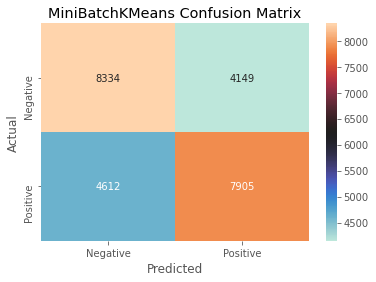

In [39]:
sn.heatmap(confusion_matrix(y_test, pred), annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')

sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('MiniBatchKMeans Confusion Matrix')

We have obtained than 65% accuracy in predicting whether the review message is positive or negative, and we have performed feature extraction from the raw text in the process.

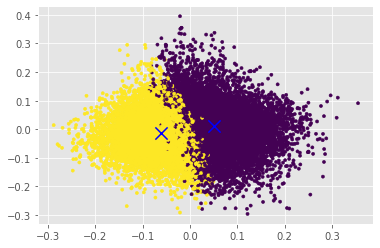

In [40]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features.toarray())
reduced_cluster_centers = pca.transform(model.cluster_centers_)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=model.predict(features), s=10)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], marker='x', s=150, c='b')

## Supervised Learning Approach

### MultinomialNB

In [41]:
#instantiate the model (with the default parameters)
model = MultinomialNB()

#fit the model with data (occurs in-place)
model.fit(features, y_train)

MultinomialNB()

In [42]:
print ('Training accuracy of MultinomialNB using TfIdfVectorizer',accuracy_score(y_train, model.predict(features)))

Training accuracy of MultinomialNB using TfIdfVectorizer 0.836


In [43]:
features_test = bag_of_words.transform(X_test)
pred = model.predict(features_test)
pred = pd.DataFrame(pred)
print("accuracy score: {}%".format(accuracy_score(y_test, pred)))
# accuracy score: 0.83048%
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

accuracy score: 0.83012%
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     12483
           1       0.81      0.86      0.83     12517

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

